<a href="https://colab.research.google.com/github/kumnikhil/deep-reinforcement-learning/blob/master/kite_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym==0.19.0 gym-anytrading 
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines 
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 46.9 MB/s 
Reason for being yanked: re-release with new wheels
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym 
import gym_anytrading

import tensorflow as tf
from stable_baselines import A2C
from stable_baselines.common.vec_env import DummyVecEnv



import pandas as pd
from pandas_datareader import data as pdr

import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documen

In [ ]:
def get_yahoo_data(symbol,start_date, end_date,symbol_prfx ='',symbol_sffx='.NS'):
  symb = str(symbol_prfx+symbol+symbol_sffx).upper()
  try:
    symbol_data =  pdr.get_data_yahoo(symb,start_date,end_date)
    symbol_data['symbol'] = symb
    symbol_data['source'] = 'yahoo_datareader'
  except:
    symbol_data = None
    print(f'data not found for the symbol- {symb}')
  else:
    return symbol_data.round(3)


In [ ]:
end_date = (dt.datetime.today().date()-dt.timedelta(days=1)).strftime("%Y-%m-%d")
start_date = (dt.datetime.today().date()-dt.timedelta(days=365*5+1)).strftime("%Y-%m-%d")
symb =  'RELIANCE'
print(f"Load data for {symb} for the period: {start_date}  -  {end_date}")


Load data for RELIANCE for the period: 2017-09-20  -  2022-09-19


In [ ]:
df = get_yahoo_data(symbol=symb,start_date=start_date,end_date = end_date)

In [ ]:
print(df.shape)
df.index

(1236, 8)


DatetimeIndex(['2017-09-20', '2017-09-21', '2017-09-22', '2017-09-25',
               '2017-09-26', '2017-09-27', '2017-09-28', '2017-09-29',
               '2017-10-03', '2017-10-04',
               ...
               '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-12',
               '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16',
               '2022-09-19', '2022-09-20'],
              dtype='datetime64[ns]', name='Date', length=1236, freq=None)

In [ ]:
df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,symbol,source
Date,,,,,,,,
2022-09-14,2610.00,2572.75,2575.00,2588.35,4004997.0,2588.35,RELIANCE.NS,yahoo_datareader
2022-09-15,2603.55,2556.75,2583.00,2562.70,4783723.0,2562.70,RELIANCE.NS,yahoo_datareader
2022-09-16,2553.00,2491.00,2543.75,2499.20,9330469.0,2499.20,RELIANCE.NS,yahoo_datareader
2022-09-19,2522.70,2481.35,2499.20,2502.45,3498286.0,2502.45,RELIANCE.NS,yahoo_datareader
2022-09-20,2537.70,2494.70,2522.45,2502.85,3880011.0,2502.85,RELIANCE.NS,yahoo_datareader


In [ ]:
window_size = 10 #how many previous timesteps our trading bot has as reference points when it makes its next trade
"""frame_bound :specifies the start and end of our df. 
      The first parameter on the frame_bound should always be equal to the window_size so that it has the five sets of previous data. 
      For the second parameter, you can adjust it to any value of your choice depending on your data."""

frame_bound = (window_size,df.shape[0]-window_size)
env = gym.make(f'stocks-v0', df=df, frame_bound=frame_bound, window_size=window_size)

In [ ]:
env.signal_features

array([[ 839.195,    0.   ],
       [ 833.45 ,   -5.745],
       [ 809.725,  -23.725],
       ...,
       [2530.5  ,  -29.9  ],
       [2569.8  ,   39.3  ],
       [2596.85 ,   27.05 ]])

In [ ]:
env.action_space

Discrete(2)

info {'total_reward': 802.9620000000009, 'total_profit': 0.02042943486776594, 'position': 1}


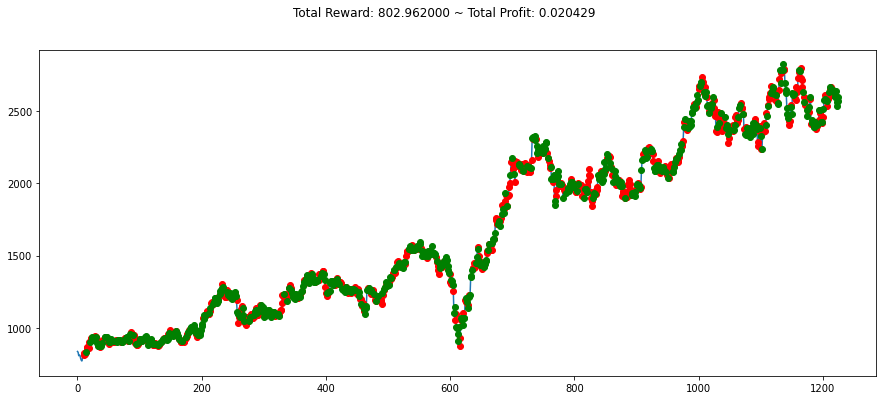

In [ ]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [ ]:
env_maker = lambda:gym.make(f'stocks-v0', df=df, frame_bound=frame_bound, window_size=window_size)
env = DummyVecEnv([env_maker])

In [ ]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




----------------------------------
| explained_variance | -1.07e-05 |
| fps                | 8         |
| nupdates           | 1         |
| policy_entropy     | 0.693     |
| total_timesteps    | 5         |
| value_loss         | 1.56e+03  |
----------------------------------
---------------------------------
| explained_variance | 0.000419 |
| fps                | 242      |
| nupdates           | 100      |
| policy_entropy     | 0.693    |
| total_timesteps    | 500      |
| value_loss         | 3.57e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.00144 |
| fps                | 289      |
| nupdates           | 200      |
| policy_entropy     | 0.693    |
| total_timesteps    | 1000     |
| value_loss         | 9.34e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.0107   |
| fps                | 306      |
| nupdates           | 300      |
| policy_entropy     | 0.693    |
| tota

KeyboardInterrupt: ignored

In [ ]:
env = gym.make('stocks-v0', df=df, frame_bound=frame_bound, window_size=window_size)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 394.01199999999915, 'total_profit': 0.016901209700850017, 'position': 1}


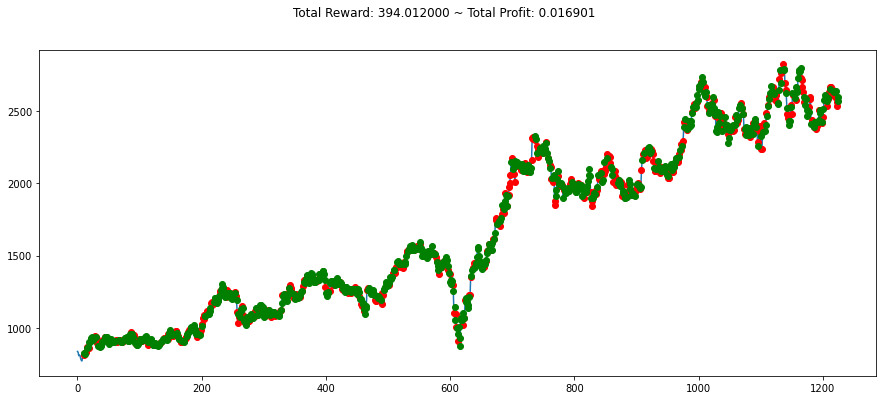

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()